# INTRODUCTION TO THE PROBLEM AND DATASET

## PROBLEM STATEMENT

> A leading fresh produce supply chain company is revolutionizing the agricultural sector by integrating `technology` and `automation`. It directly sources vegetables from `farmers` and delivers them to businesses within hours, ensuring `quality` and `efficiency`. To optimize operations, an `AI-driven` classification system is needed for accurate and automated sorting.  

> The challenge lies in differentiating between `onions`, `potatoes`, `tomatoes`, and `market scenes` under varying `lighting`, `angles`, and `backgrounds`. A `multiclass classifier` must be developed to correctly categorize these images while identifying unrelated ones as `noise`, reducing manual effort and improving accuracy. 


## OBJECTIVE OF THE PROJECT

> This project aims to develop a `deep learning-based` image classifier that accurately identifies `onions`, `potatoes`, and `tomatoes` while filtering out `market scenes`. The model should handle variations in `lighting`, `angles`, and `backgrounds` to ensure `reliable performance`.  

> By automating `produce identification`, the system will minimize `manual sorting`, enhance `inventory management`, and optimize `distribution`. This will help reduce `errors`, decrease `waste`, and improve overall `supply chain efficiency`.

# Import Libraries

In [19]:
import os
import numpy as np
import tensorflow as tf
tf.keras.utils.set_random_seed(111)
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import sklearn.metrics as metrics
%matplotlib inline

In [3]:
import gdown

# File ID from your URL
file_id = "1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT"
url = f"https://drive.google.com/uc?id={file_id}"

# Output file name
output = "downloaded_file"

# Download the file
gdown.download(url, output, quiet=False)

print(f"File downloaded as {output}")


Downloading...
From (original): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT
From (redirected): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT&confirm=t&uuid=27cd2878-3ab5-40f6-9960-76a2840f9560
To: c:\Users\saina\Desktop\DS_ML_AI\Scaler\Module_20_Computer_Vision\Case_studies\Ninja_cart\Multiclass_Vegetable_Image_Classification_Using_Deep_Learning\notebook\downloaded_file
100%|██████████| 275M/275M [00:54<00:00, 5.01MB/s] 

File downloaded as downloaded_file


In [4]:
import zipfile
import os

# File to be unzipped
zip_file = "downloaded_file"  # Update this if the file has a specific extension like 'downloaded_file.zip'

# Output directory
output_dir = "unzipped_files"

# Check if the file exists and is a ZIP file
if zipfile.is_zipfile(zip_file):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Unzipping the file
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    print(f"Files extracted to: {output_dir}")
else:
    print(f"{zip_file} is not a valid ZIP file.")


Files extracted to: unzipped_files


# Loading Data

In [ ]:
# def load_data(base_dir="ninjacart_data"):
#     # checking if the data folders are present
#     assert os.path.exists(f"{base_dir}/train") and os.path.exists(f"{base_dir}/test")

#     print('\nLoading Data...')
#     train_data = tf.keras.utils.image_dataset_from_directory(
#         f"{base_dir}/train", shuffle=True, label_mode='categorical'
#     )
#     test_data = tf.keras.utils.image_dataset_from_directory(
#         f"{base_dir}/test", shuffle=False, label_mode='categorical'
#     )
#     return train_data, test_data, train_data.class_names

In [ ]:
# train_data, test_data, class_names = load_data()

In [20]:
import tensorflow as tf
import os

def load_data(base_dir="unzipped_files/ninjacart_data", validation_split=0.2):
    # Ensure data folders exist
    assert os.path.exists(f"{base_dir}/train") and os.path.exists(f"{base_dir}/test")

    print('\nLoading Data...')

    # Load the train dataset and apply validation split
    train_data = tf.keras.preprocessing.image_dataset_from_directory(
        f"{base_dir}/train",
        shuffle=True,
        label_mode='categorical',
        validation_split=validation_split,
        subset='training',  # For training subset
        seed=123
    )

    # Validation data (from the same directory, using validation_split)
    val_data = tf.keras.preprocessing.image_dataset_from_directory(
        f"{base_dir}/train",
        shuffle=True,
        label_mode='categorical',
        validation_split=validation_split,
        subset='validation',  # For validation subset
        seed=123
    )

    # Load the test data (no split applied here)
    test_data = tf.keras.preprocessing.image_dataset_from_directory(
        f"{base_dir}/test",
        shuffle=False,
        label_mode='categorical'
    )

    # Get the class names from train data
    class_names = train_data.class_names

    # Print class names
    print(f"Class names: {class_names}")

    return train_data, val_data, test_data, class_names

# Call the function to load data
train_data, val_data, test_data, class_names = load_data()



Loading Data...
Found 3135 files belonging to 4 classes.
Using 2508 files for training.
Found 3135 files belonging to 4 classes.
Using 627 files for validation.
Found 351 files belonging to 4 classes.
Class names: ['indian market', 'onion', 'potato', 'tomato']


In [ ]:
# import os
# class_dirs = os.listdir('/content/ninjacart_data/train')  # List class folders
# for class_dir in class_dirs:
#     class_path = os.path.join('/content/ninjacart_data/train', class_dir)
#     print(f"{class_dir}: {len(os.listdir(class_path))} files")


# Data Preprocessing: Resizing, Standardization

In [21]:
def preprocess(train_data, val_data, test_data, target_height=128, target_width=128):

    # Data Processing Stage with resizing and rescaling operations
    data_preprocess = keras.Sequential(
        name="data_preprocess",
        layers=[
            layers.Resizing(target_height, target_width),
            layers.Rescaling(1.0/255),
        ]
    )

    # Perform Data Processing on the train, val, test dataset
    train_ds = train_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds

In [22]:
train_ds, val_ds, test_ds = preprocess(train_data, val_data, test_data)

# Model CNN

In [23]:
def baseline(height=128, width=128):
    num_classes = 4
    hidden_size = 256

    model = keras.Sequential(
        name="model_cnn",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", activation='relu', input_shape=(height, width, 3)),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(units=hidden_size, activation='relu'),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [24]:
model = baseline()
model.summary()

C:\Users\saina\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "model_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,778,948 (64.01 MB)

 Trainable params: 16,778,948 (64.01 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
def compile_train_v1(model, train_ds, val_ds, ckpt_path="/tmp/checkpoint.weights.h5"):
    epochs = 10
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model_fit = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[
            keras.callbacks.ModelCheckpoint(
                ckpt_path, 
                save_weights_only=True, 
                monitor='val_accuracy', 
                mode='max', 
                save_best_only=True
            ),
        ]
    )
    return model_fit


In [26]:
model_fit = compile_train_v1(model, train_ds, val_ds)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 0.4793 - loss: 3.0117 - val_accuracy: 0.7305 - val_loss: 0.7435
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.8000 - loss: 0.5540 - val_accuracy: 0.7943 - val_loss: 0.5653
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - accuracy: 0.9108 - loss: 0.2806 - val_accuracy: 0.8166 - val_loss: 0.5695
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.9596 - loss: 0.1609 - val_accuracy: 0.8086 - val_loss: 0.6012
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 0.9701 - loss: 0.1069 - val_accuracy: 0.8038 - val_loss: 0.6257
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.9779 - loss: 0.0746 - val_accuracy: 0.7959 - val_loss: 0.7690
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 0.9886 - loss: 0.0558 - val_accuracy: 0.8038 - val_loss: 0.5754
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - accuracy: 0.9921 - loss: 0.0374 - val_accu

# Plot Train and Validation Accuracy

In [12]:
# helper function to annotate maximum values in the plots
def annot_max(x,y, xytext=(0.94,0.96), ax=None, only_y=True):
    xmax = x[np.argmax(y)]
    ymax = max(y)
    if only_y:
        text = "{:.2f}%".format(ymax)
    else:
        text= "x={:.2f}, y={:.2f}%".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=xytext, **kw)

def plot_accuracy(model_fit):
    #accuracy graph
    x = range(0,len(model_fit.history['accuracy']))
    y_train = [acc * 100 for acc in model_fit.history['accuracy']]
    y_val = [acc * 100 for acc in model_fit.history['val_accuracy']]

    plt.plot(x, y_train, label='Train', color='b')
    annot_max(x, y_train, xytext=(0.7,0.9))
    plt.plot(x, y_val, label='Val', color='r')
    annot_max(x, y_val, xytext=(0.8,0.7))
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

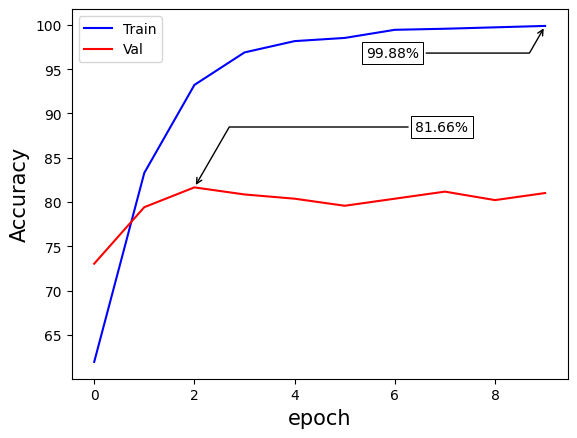

In [27]:
plot_accuracy(model_fit)

# Analyze Result on Test Dataset

In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

def print_accuracy_stats(model, ds, class_names, ckpt_path="/tmp/checkpoint.weights.h5"):
    # Load model weights
    model.load_weights(ckpt_path)
    
    # Get true labels and predictions
    true_onehot = tf.concat([y for _, y in ds], axis=0)
    true_categories = tf.argmax(true_onehot, axis=1).numpy()
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1).numpy()

    # Calculate accuracy
    test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
    print(f'\nTest Accuracy: {test_acc:.2f}%\n')


def plot_confusion_matrix(model, ds, class_names, ckpt_path="/tmp/checkpoint.weights.h5"):
    # Load model weights
    model.load_weights(ckpt_path)
    
    # Get true labels and predictions
    true_onehot = tf.concat([y for _, y in ds], axis=0)
    true_categories = tf.argmax(true_onehot, axis=1).numpy()
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1).numpy()

    # Compute confusion matrix
    cm = metrics.confusion_matrix(true_categories, predicted_categories)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='g', 
        cmap="YlGnBu", 
        xticklabels=class_names, 
        yticklabels=class_names
    )
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

Test Accuracy: 71.23%

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


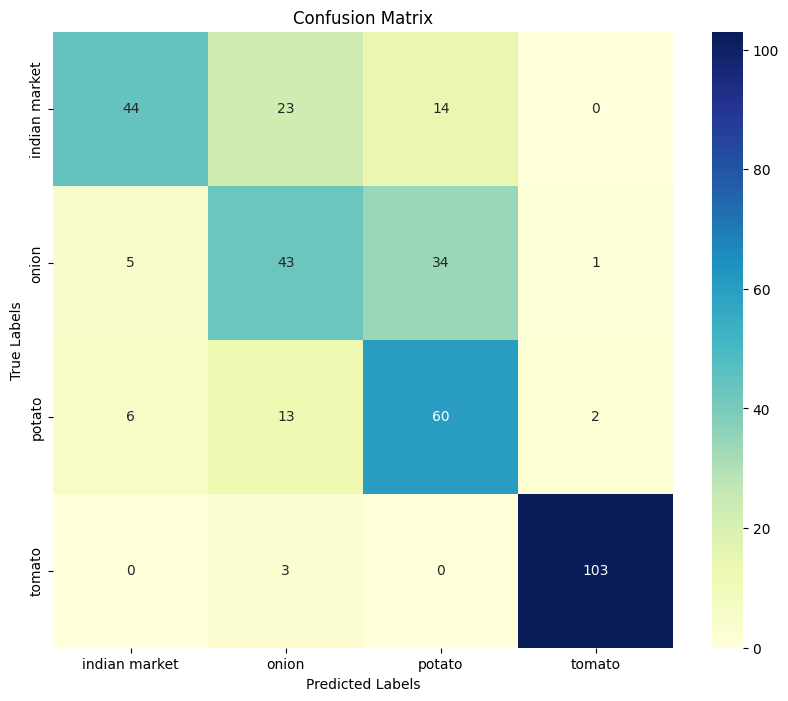

In [29]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# Modification in Model CNN 1

In [30]:
def arch_1(height=128, width=128):
    num_classes = 4
    hidden_size = 256

    model = keras.Sequential(
        name="model_cnn_1",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", activation='relu', input_shape=(height, width, 3)),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same", activation='relu'),
            # layers.MaxPooling2D(),
            # layers.Flatten(),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size, activation='relu'),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [31]:
model = arch_1()
model.summary()

C:\Users\saina\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "model_cnn_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 459,428 (1.75 MB)

 Trainable params: 459,428 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
def compile_train_v1(model, train_ds, val_ds, epochs=10, ckpt_path="/tmp/checkpoint.weights.h5"):
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model with a ModelCheckpoint callback
    model_fit = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[
            keras.callbacks.ModelCheckpoint(
                ckpt_path,
                save_weights_only=True,
                monitor='val_accuracy',
                mode='max',
                save_best_only=True
            )
        ]
    )
    return model_fit


# Increase epochs

In [34]:
model_fit = compile_train_v1(model, train_ds, val_ds, epochs=30)

Epoch 1/30


79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 0.4165 - loss: 1.2146 - val_accuracy: 0.5869 - val_loss: 0.9023
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.6195 - loss: 0.8362 - val_accuracy: 0.7799 - val_loss: 0.5716
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.7752 - loss: 0.5753 - val_accuracy: 0.8102 - val_loss: 0.4948
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.7908 - loss: 0.5284 - val_accuracy: 0.8373 - val_loss: 0.4342
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.8124 - loss: 0.4887 - val_accuracy: 0.8102 - val_loss: 0.4989
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.8213 - loss: 0.4783 - val_accuracy: 0.7943 - val_loss: 0.5681
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.8399 - loss: 0.4194 - val_accuracy: 0.8581 - val_loss: 0.3470
Epoch 8/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.8557 - loss: 0.3722 - val_accuracy: 0.8102 - v

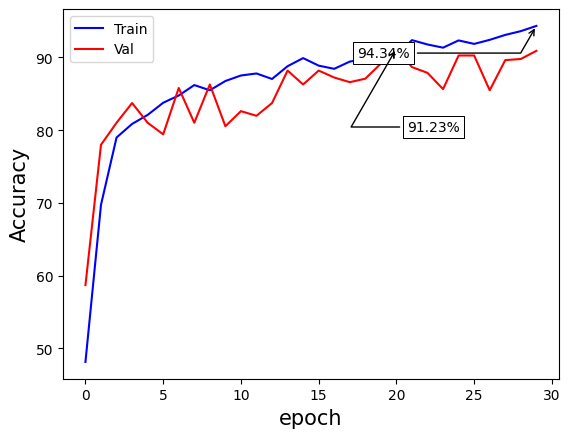

In [35]:
plot_accuracy(model_fit)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Test Accuracy: 86.04%

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


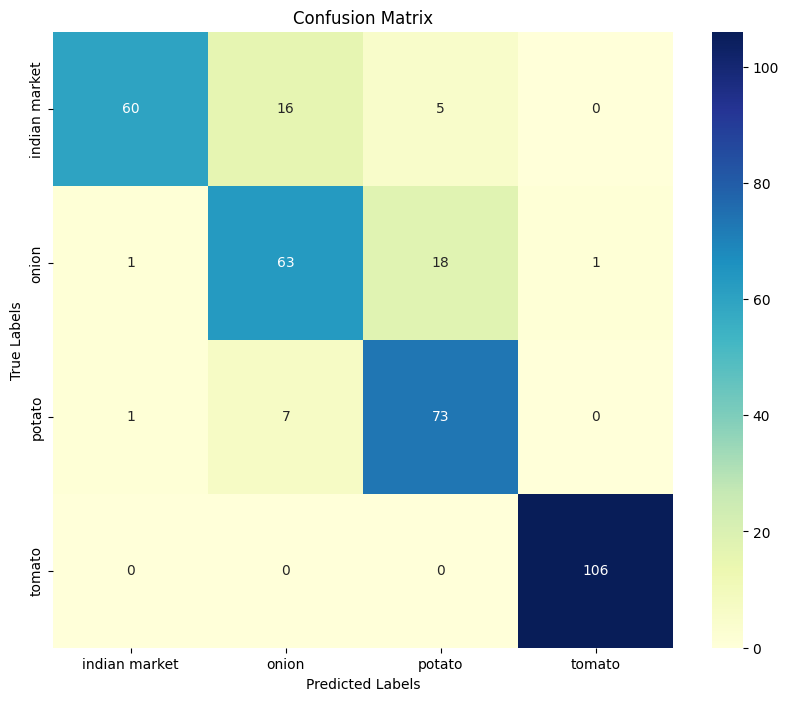

In [36]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# Modification in Model CNN 2

In [37]:
def arch_2(height=128, width=128):
    num_classes = 4
    hidden_size = 256

    model = keras.Sequential(
        name="model_cnn_2",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", input_shape=(height, width, 3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            # layers.MaxPooling2D(),
            # layers.Flatten(),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [38]:
model = arch_2()
model.summary()

C:\Users\saina\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "model_cnn_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 256)            │             

 Total params: 462,436 (1.76 MB)

 Trainable params: 460,932 (1.76 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [39]:
model_fit = compile_train_v1(model, train_ds, val_ds, epochs=30)

Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - accuracy: 0.6813 - loss: 1.0109 - val_accuracy: 0.2711 - val_loss: 1.7445
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - accuracy: 0.7761 - loss: 0.6346 - val_accuracy: 0.5343 - val_loss: 1.2170
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 0.7900 - loss: 0.5682 - val_accuracy: 0.5534 - val_loss: 1.4729
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step - accuracy: 0.8221 - loss: 0.4723 - val_accuracy: 0.6061 - val_loss: 1.3307
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - accuracy: 0.8078 - loss: 0.5225 - val_accuracy: 0.5965 - val_loss: 1.2596
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - accuracy: 0.8349 - loss: 0.4349 - val_accuracy: 0.6380 - val_loss: 1.0657
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 171ms/step - accuracy: 0.8510 - loss: 0.3971 - val_accuracy: 0.7751 - val_loss: 0.5724
Epoch 8/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step - accuracy: 0.8571 - loss: 0.3820 - val_accu

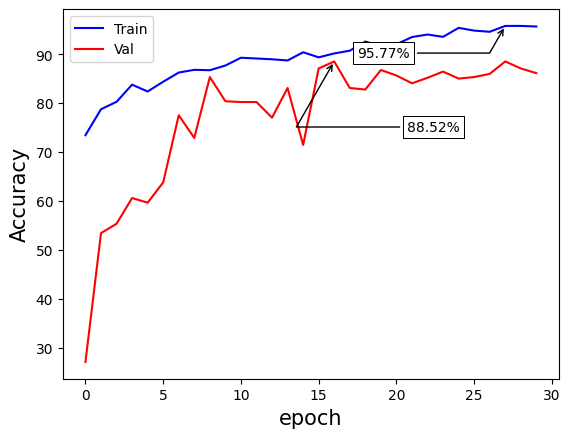

In [40]:
plot_accuracy(model_fit)

# Modification ReduceLRonPlateau and EarlyStopping

In [41]:
def compile_train_v2(model, train_ds, val_ds, epochs=10, ckpt_path="/tmp/checkpoint.weights.h5"):
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.3, patience=5, min_lr=0.00001
        ),
        keras.callbacks.ModelCheckpoint(
            ckpt_path, 
            save_weights_only=True, 
            monitor='val_accuracy', 
            mode='max', 
            save_best_only=True
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, min_delta=0.001, mode='min'
        )
    ]
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model_fit = model.fit(
        train_ds, 
        validation_data=val_ds, 
        epochs=epochs, 
        callbacks=callbacks
    )
    return model_fit


In [42]:
model = arch_2()
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=50)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - accuracy: 0.6448 - loss: 1.0878 - val_accuracy: 0.3876 - val_loss: 1.2645 - learning_rate: 0.0010
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - accuracy: 0.7577 - loss: 0.6638 - val_accuracy: 0.4290 - val_loss: 1.2274 - learning_rate: 0.0010
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - accuracy: 0.7896 - loss: 0.5495 - val_accuracy: 0.5327 - val_loss: 1.0583 - learning_rate: 0.0010
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.7969 - loss: 0.5337 - val_accuracy: 0.6188 - val_loss: 0.9340 - learning_rate: 0.0010
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 0.8209 - loss: 0.4619 - val_accuracy: 0.5821 - val_loss: 1.3432 - learning_rate: 0.0010
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - accuracy: 0.8280 - loss: 0.4550 - val_accuracy: 0.6380 - val_loss: 1.0950 - learning_rate: 0.0010
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 0.8318 - loss: 0.

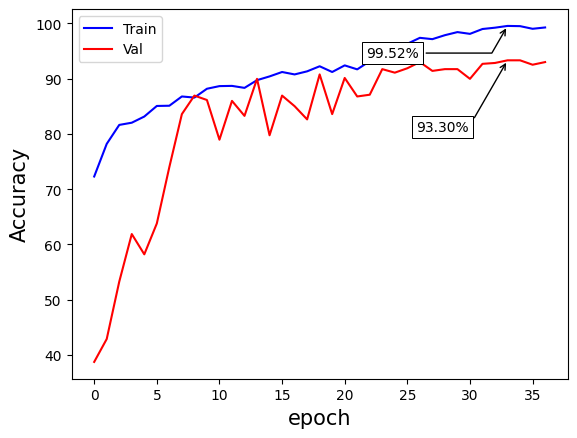

In [43]:
plot_accuracy(model_fit)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step

Test Accuracy: 90.60%

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


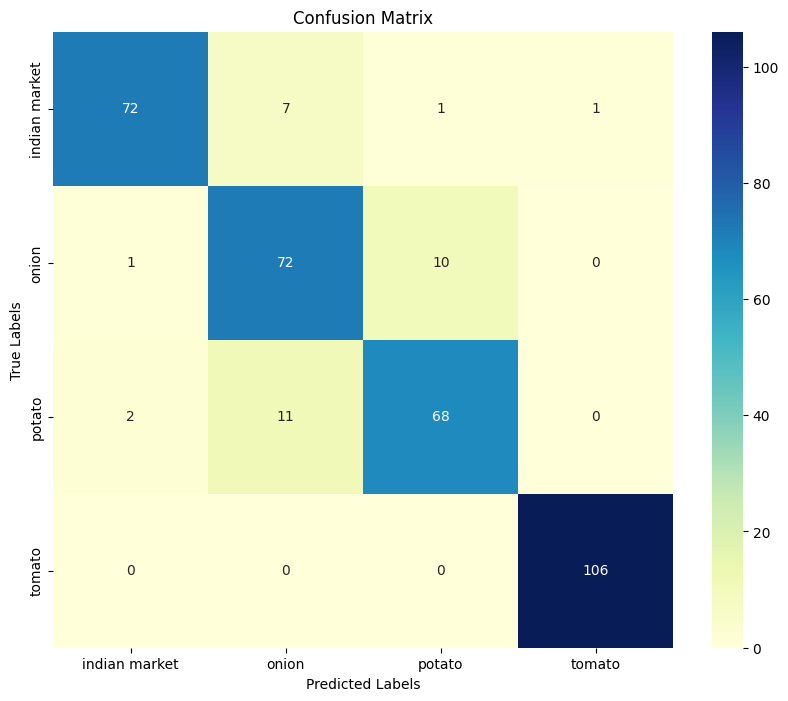

In [44]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# Modification in Model CNN add L2 Regularization

In [45]:
def arch_3(height=128, width=128):
    num_classes = 4
    hidden_size = 256

    model = keras.Sequential(
        name="model_cnn_3",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", input_shape=(height, width, 3),
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            # layers.MaxPooling2D(),
            # layers.Flatten(),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size, kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [46]:
model = arch_3()
model.summary()

C:\Users\saina\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "model_cnn_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 256)            │             

 Total params: 462,436 (1.76 MB)

 Trainable params: 460,932 (1.76 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [47]:
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - accuracy: 0.6401 - loss: 1.7789 - val_accuracy: 0.3126 - val_loss: 1.9390 - learning_rate: 0.0010
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 0.7537 - loss: 1.3131 - val_accuracy: 0.5375 - val_loss: 1.7109 - learning_rate: 0.0010
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 0.7802 - loss: 1.1942 - val_accuracy: 0.3923 - val_loss: 2.2382 - learning_rate: 0.0010
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - accuracy: 0.7863 - loss: 1.1602 - val_accuracy: 0.4928 - val_loss: 2.0014 - learning_rate: 0.0010
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - accuracy: 0.8176 - loss: 0.9991 - val_accuracy: 0.6491 - val_loss: 1.3192 - learning_rate: 0.0010
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - accuracy: 0.8212 - loss: 0.9563 - val_accuracy: 0.6778 - val_loss: 1.5089 - learning_rate: 0.0010
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - accuracy: 0.8274 - l

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step

Test Accuracy: 91.17%

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


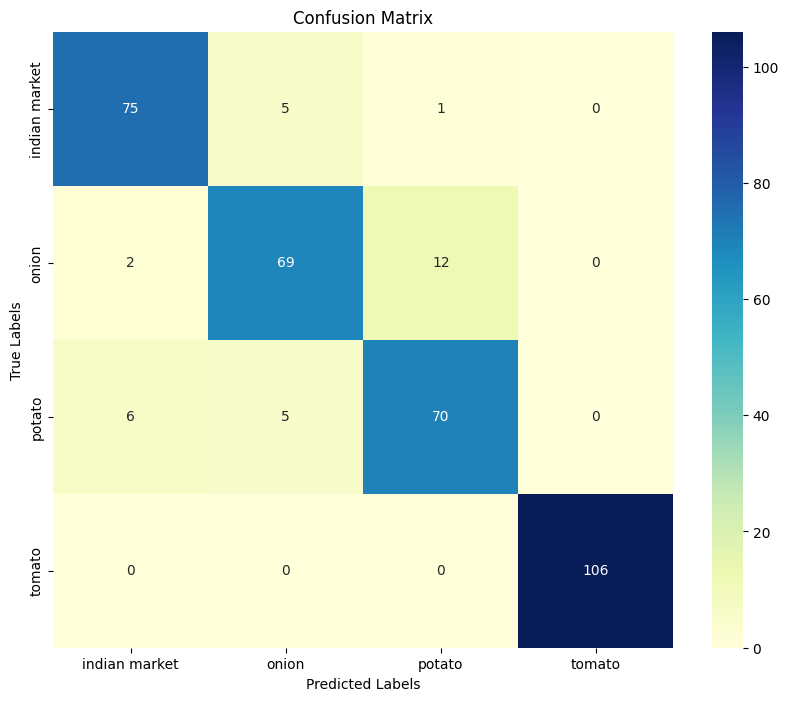

In [48]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# Data Augmentation

In [53]:
# Functions to Load and Visualize Samples
# Load Sample
import tensorflow.keras.utils as keras_utils

def load_sample(image_path, output_size=(300, 300)):
    # Load the image using the provided path
    sample = keras_utils.load_img(image_path, target_size=output_size)
    sample = keras_utils.img_to_array(sample)
    return sample
# # Load the image
# sample = load_sample(image_path)
# print(f"Sample image loaded from: {image_path}")


# Visualize Sample
def show_images(imgs, num_rows, num_cols, scale=2):
    # show augmented images in a grid layout
    aspect_ratio = imgs[0].shape[0]/imgs[0].shape[1]
    figsize = (num_cols * scale, num_rows * scale * aspect_ratio)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            if num_rows != 1:
                axes[i][j].imshow(imgs[i * num_cols + j].numpy().astype("uint8"))
                axes[i][j].axes.get_xaxis().set_visible(False)
                axes[i][j].axes.get_yaxis().set_visible(False)
            else:
                plt.imsave('test.png', imgs[i * num_cols + j].numpy()[0].astype("uint8"))
                # print(imgs[i * num_cols + j].numpy()[0].astype("uint8"))
                axes[j].imshow(imgs[i * num_cols + j].numpy().astype("uint8"))
                axes[j].axes.get_xaxis().set_visible(False)
                axes[j].axes.get_yaxis().set_visible(False)
    plt.subplots_adjust(hspace=0.1, wspace=0)
    return axes

def apply(img, aug, num_rows=1, num_cols=4, scale=3):
    # apply augmentation multiple times to obtain different samples
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

In [50]:
# Required to reset the mode to training!
tf.keras.backend.clear_session()

In [51]:
tf.compat.v1.reset_default_graph

<function tensorflow.python.framework.ops.reset_default_graph() -> None>

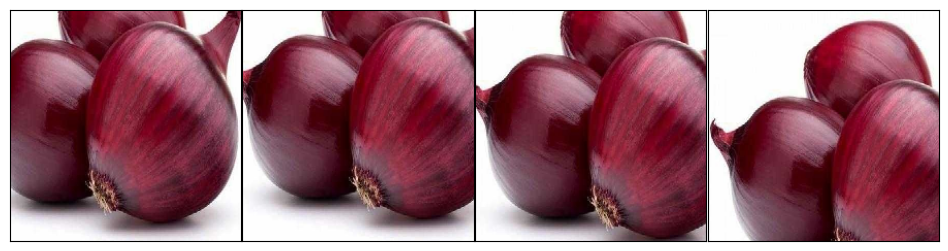

In [56]:
from keras.layers import RandomCrop

# Direct path to the image
image_path = r"unzipped_files\ninjacart_data\train\onion\0WPOOEUP7PG0.jpg"

sample = load_sample(image_path,output_size=(300, 300))
aug_layer = RandomCrop(
    height = 224,
    width = 224,
)

apply(sample, aug_layer)

In [57]:
# Alternative Implementation using tf.image
random_crop = tf.image.random_crop(value=sample, size=(224, 224, 3))

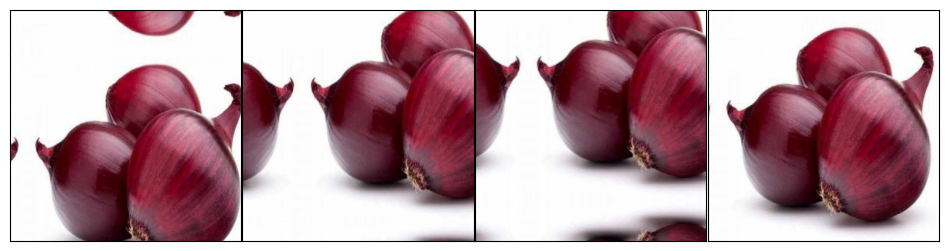

In [60]:
from keras.layers import RandomTranslation

sample = load_sample(image_path,output_size=(300, 300))
aug_layer = RandomTranslation(
    height_factor = (-0.2, 0.3),
    width_factor = (-0.2, 0.3),
)

apply(sample, aug_layer)

In [61]:
# Alternative Implementation using tf.image
random_shift = tf.keras.preprocessing.image.random_shift(sample, hrg = 0.2, wrg = 0.5)

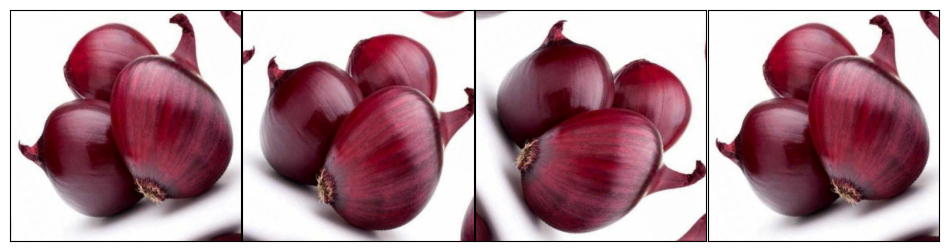

In [62]:
from keras.layers import RandomRotation

sample = load_sample(image_path,output_size=(300, 300))
aug_layer = RandomRotation(
    factor = (-0.2, 0.3),
)

apply(sample, aug_layer)

In [63]:
# Alternative Implementation using tf.image
random_rotation = tf.keras.preprocessing.image.random_rotation(sample, rg=500, channel_axis = 2, row_axis=0, col_axis=1)

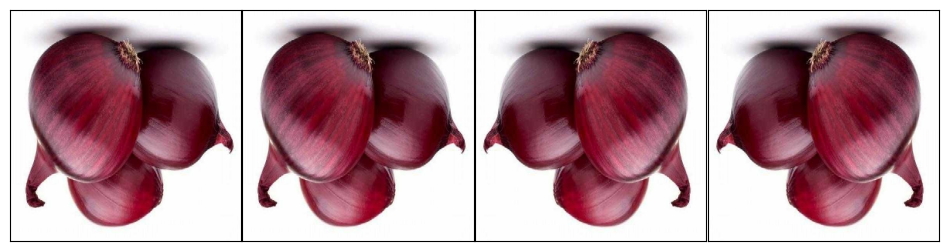

In [64]:
from keras.layers import RandomFlip

sample = load_sample(image_path,output_size=(300, 300))
aug_layer = RandomFlip()

apply(sample, aug_layer)

In [65]:
# Alternative Implementation using tf.image
randomflip = tf.image.random_flip_left_right(sample, 10)

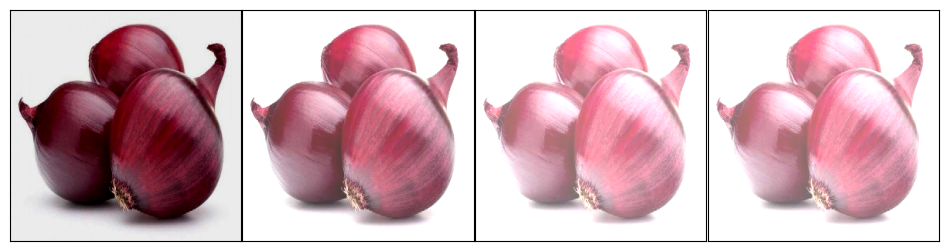

In [66]:
sample = load_sample(image_path,output_size=(300, 300))

try:
    from tensorflow.keras.layers import RandomBrightness
    aug_layer = RandomBrightness(factor=(-0.2, 0.5))
except ImportError:
    print("This Version of tensorflow doesn't have tensorflow.keras.layers.RandomBrightness class, using tf.image.random_brightness instead")
    aug_layer = lambda x: tf.image.random_brightness(x, 100)
apply(sample, aug_layer)

In [67]:
# Alternative Implementation using tf.image
random_bright = tf.image.random_brightness(sample, 100)

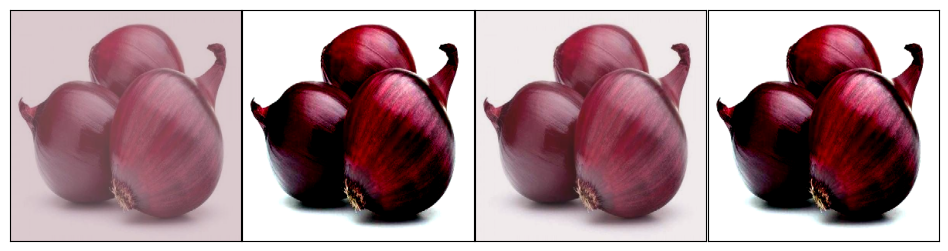

In [68]:
from keras.layers import RandomContrast

sample = load_sample(image_path,output_size=(300, 300))
aug_layer = RandomContrast(factor=(0.5, 0.9))

apply(sample, aug_layer)

In [69]:
# Alternative Implementation using tf.image
random_contrast = tf.image.random_contrast(sample, 0.5, 10)

In [156]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

def preprocess_v2(train_data, val_data, test_data, target_height=128, target_width=128):
    # Data preprocessing pipeline for validation and test datasets
    data_preprocess = Sequential(
        name="data_preprocess",
        layers=[
            layers.Resizing(target_height, target_width),  # Resize to target size
            layers.Rescaling(1.0 / 255),  # Normalize pixel values to [0, 1]
        ],
    )

    # Data augmentation pipeline for training dataset
    data_augmentation = Sequential(
        name="data_augmentation",
        layers=[
            layers.Resizing(156, 156),  # Resize to a larger size first
            layers.RandomCrop(target_height, target_width),  # Randomly crop to target size
            layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Random translation
            layers.RandomRotation(0.2),  # Random rotation (in radians)
            layers.RandomBrightness(0.2),  # Random brightness adjustment
            layers.RandomContrast(0.2),  # Random contrast adjustment
            layers.Rescaling(1.0 / 255),  # Normalize pixel values to [0, 1]
        ],
    )

    # Apply data augmentation to the training dataset
    train_aug_ds = train_data.map(
        lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)

    # Apply preprocessing to the validation dataset
    val_aug_ds = val_data.map(
        lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)

    # Apply preprocessing to the test dataset
    test_aug_ds = test_data.map(
        lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)

    return train_aug_ds, val_aug_ds, test_aug_ds


In [157]:
train_aug_ds, val_aug_ds, test_aug_ds = preprocess_v2(train_data, val_data, test_data)

In [72]:
model = arch_3()
model.summary()

C:\Users\saina\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "model_cnn_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 256)            │             

 Total params: 462,436 (1.76 MB)

 Trainable params: 460,932 (1.76 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [73]:
model_fit = compile_train_v2(model, train_aug_ds, val_aug_ds, epochs=100)

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 227ms/step - accuracy: 0.6409 - loss: 1.7106 - val_accuracy: 0.2711 - val_loss: 2.3203 - learning_rate: 0.0010
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 234ms/step - accuracy: 0.7424 - loss: 1.3513 - val_accuracy: 0.2807 - val_loss: 2.8769 - learning_rate: 0.0010
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 241ms/step - accuracy: 0.7897 - loss: 1.1723 - val_accuracy: 0.3525 - val_loss: 2.7865 - learning_rate: 0.0010
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 232ms/step - accuracy: 0.7834 - loss: 1.1049 - val_accuracy: 0.5821 - val_loss: 1.5905 - learning_rate: 0.0010
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 235ms/step - accuracy: 0.7852 - loss: 1.0850 - val_accuracy: 0.5678 - val_loss: 1.8111 - learning_rate: 0.0010
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 235ms/step - accuracy: 0.8093 - loss: 1.0245 - val_accuracy: 0.7974 - val_loss: 1.0281 - learning_rate: 0.0010
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 225ms/step - accuracy: 0.8157 - l

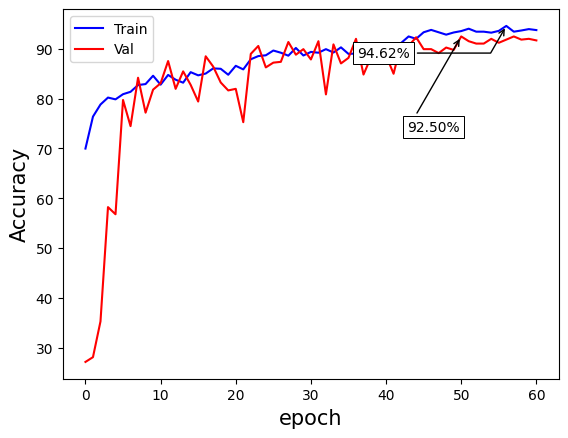

In [74]:
plot_accuracy(model_fit)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step

Test Accuracy: 90.03%

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


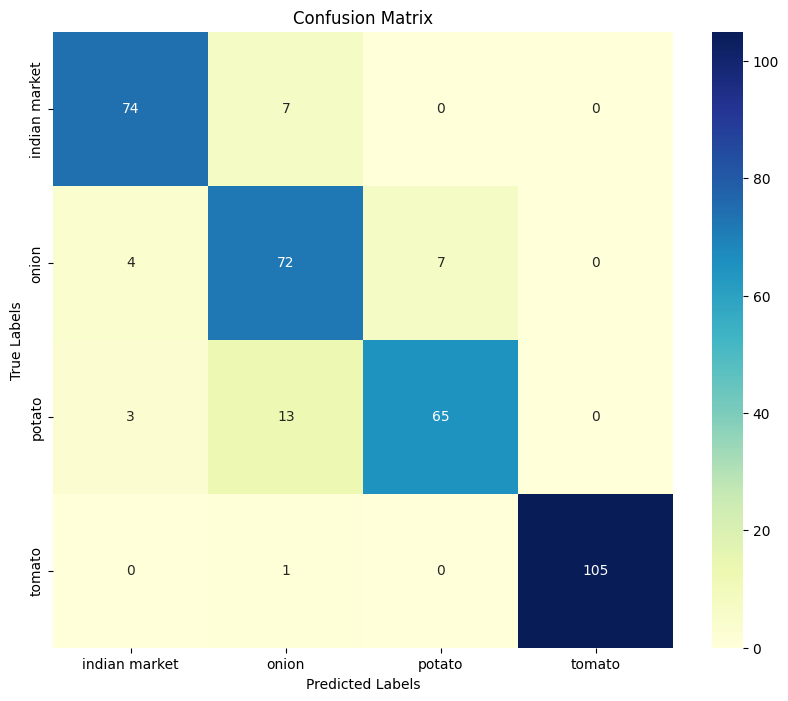

In [75]:
print_accuracy_stats(model, test_aug_ds, class_names)
plot_confusion_matrix(model, test_aug_ds, class_names)

In [76]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import glob
import tensorflow as tf
from tensorflow import keras # this allows <keras.> instead of <tf.keras.>
from tensorflow.keras import layers # this allows <layers.> instead of <tf.keras.layers.>
tf.keras.utils.set_random_seed(111) # set random seed

# To supress any warnings during the flow
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'font.size': 14})

In [78]:
import os
import glob
import random
import tensorflow as tf

class_dirs = os.listdir("unzipped_files/ninjacart_data/train/")  # List all directories inside "train" folder
image_dict = {}  # Dict to store image array(key) for every class(value)
count_dict = {}  # Dict to store count of files(key) for every class(value)

# Iterate over all class_dirs
for cls in class_dirs:
    # Get list of all paths inside the subdirectory (without quotes around the path string)
    file_paths = glob.glob(f"unzipped_files/ninjacart_data/train/{cls}/*")
    
    # Count number of files in each class and add it to count_dict
    count_dict[cls] = len(file_paths)
    
    # Check if file_paths is not empty before selecting a random item
    if file_paths:
        # Select random item from list of image paths
        image_path = random.choice(file_paths)
        
        # Load image using keras utility function and save it in image_dict
        image_dict[cls] = tf.keras.utils.load_img(image_path)
    else:
        print(f"No images found for class '{cls}'")

# Optionally, print the count_dict and image_dict to see the result
print("Class-wise image count:", count_dict)


Class-wise image count: {'indian market': 599, 'onion': 849, 'potato': 898, 'tomato': 789}


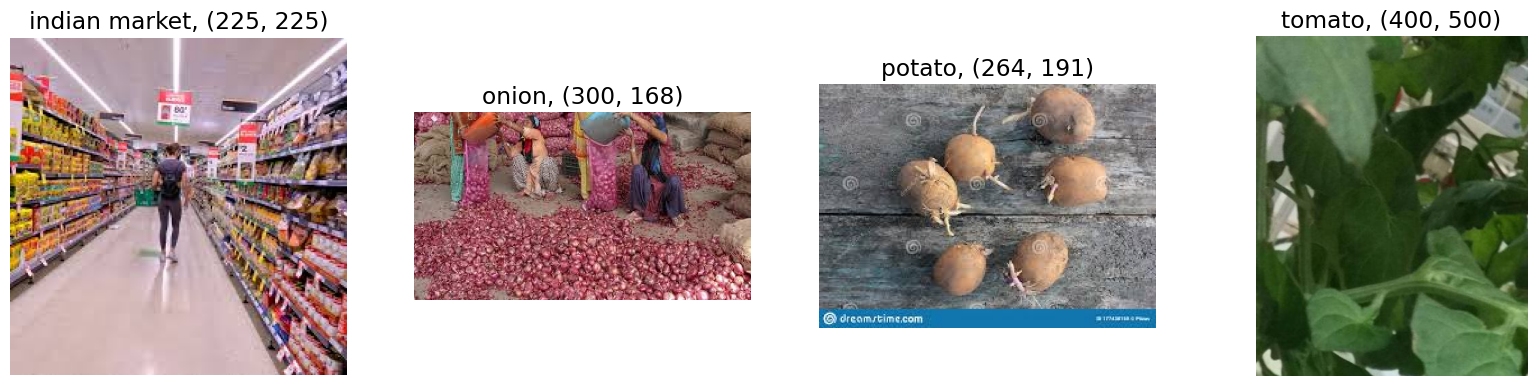

In [79]:
## Viz Random Sample from each class

plt.figure(figsize=(20, 15))
# iterate over dictionary items (class label, image array)
for i, (cls,img) in enumerate(image_dict.items()):
    # create a subplot axis
    ax = plt.subplot(3, 4, i + 1)
    # plot each image
    plt.imshow(img)
    # set "class name" along with "image size" as title
    plt.title(f'{cls}, {img.size}')
    plt.axis("off")

Count of training samples per class:
            class  count
0  indian market    599
1          onion    849
2         potato    898
3         tomato    789


<Axes: title={'center': 'Training Data Count per class'}, xlabel='class'>

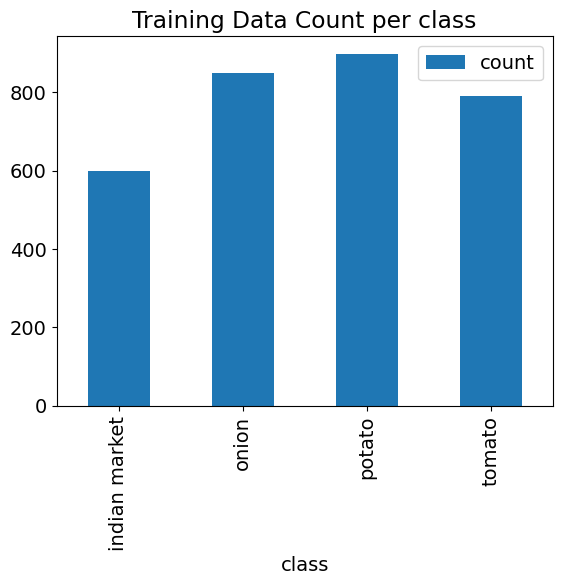

In [80]:
## Let's now Plot the Data Distribution of Training Data across Classes
df_count_train = pd.DataFrame({
    "class": count_dict.keys(),     # keys of count_dict are class labels
    "count": count_dict.values(),   # value of count_dict contain counts of each class
})
print("Count of training samples per class:\n", df_count_train)

# draw a bar plot using pandas in-built plotting function
df_count_train.plot.bar(x='class', y='count', title="Training Data Count per class")

In [81]:
print(train_data.class_names)

['indian market', 'onion', 'potato', 'tomato']


# Lenet model

In [89]:
lenet_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128,128,3)),
    tf.keras.layers.Conv2D(6, kernel_size=(5,5),
                        activation= 'sigmoid'),
    tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides= (2,2)),
    tf.keras.layers.Conv2D(16, kernel_size=(5,5),
                        activation= 'sigmoid'),
    tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides= (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation= 'sigmoid'),
    tf.keras.layers.Dense(84, activation= 'sigmoid'),
    tf.keras.layers.Dense(4, activation= 'softmax'),

])

In [90]:
lenet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 124, 124, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 62, 62, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 58, 58, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 29, 29, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 120)            │     1,614,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │           340 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,628,216 (6.21 MB)

 Trainable params: 1,628,216 (6.21 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
# Assuming lenet_model, train_ds, and val_ds are defined already
model_fit = compile_train_v2(
    model=lenet_model,
    train_ds=train_aug_ds,
    val_ds=val_aug_ds,
    epochs=100,  # Number of epochs for training
    ckpt_path="lenet_model_best.weights.h5"  # Path to save the best model weights
)


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.2947 - loss: 1.4085 - val_accuracy: 0.2663 - val_loss: 1.4075 - learning_rate: 0.0010
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.3023 - loss: 1.3725 - val_accuracy: 0.2663 - val_loss: 1.3927 - learning_rate: 0.0010
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.3005 - loss: 1.3750 - val_accuracy: 0.2663 - val_loss: 1.4104 - learning_rate: 0.0010
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.3115 - loss: 1.3727 - val_accuracy: 0.2663 - val_loss: 1.3950 - learning_rate: 0.0010
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.2916 - loss: 1.3733 - val_accuracy: 0.2663 - val_loss: 1.3853 - learning_rate: 0.0010
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.3005 - loss: 1.3719 - val_accuracy: 0.2663 - val_loss: 1.3944 - learning_rate: 0.0010
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.3064 - loss: 1.3751 - 

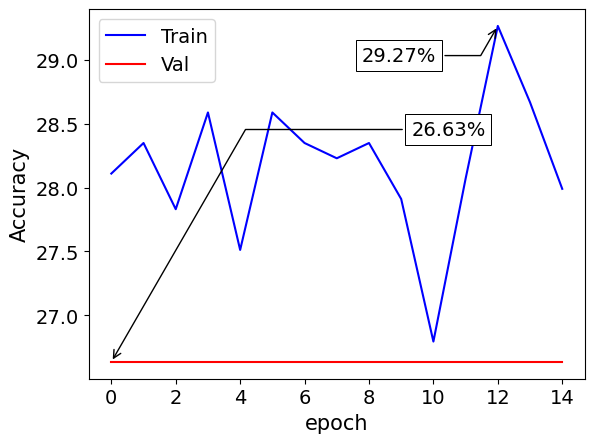

In [92]:
plot_accuracy(model_fit)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

Test Accuracy: 23.08%

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


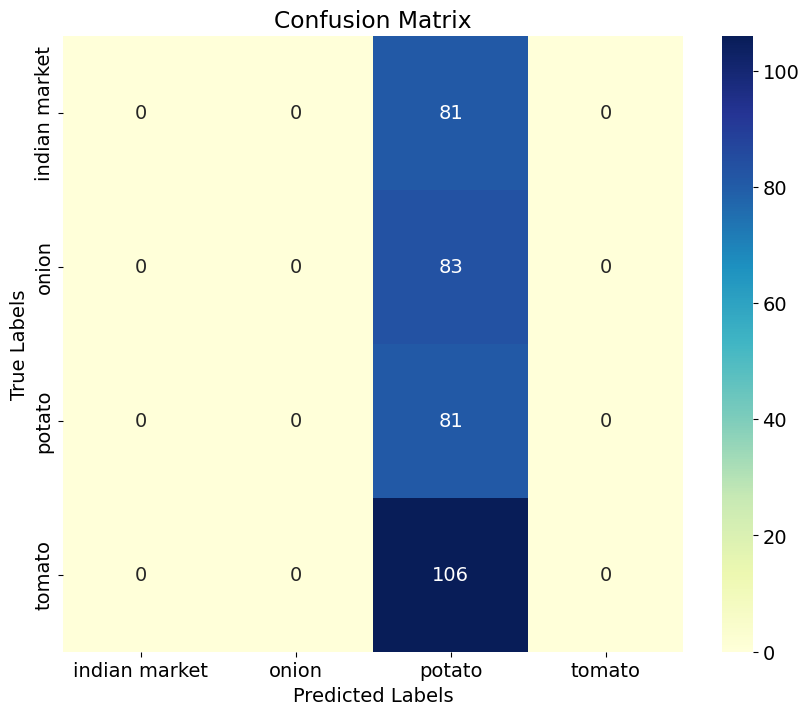

In [95]:
print_accuracy_stats(lenet_model, test_aug_ds, class_names,ckpt_path="lenet_model_best.weights.h5")
plot_confusion_matrix(lenet_model, test_aug_ds, class_names,ckpt_path="lenet_model_best.weights.h5")

# VGG 16 model

In [96]:
# VGG 16 Model
# If the commented Conv2D layer is uncommented then it becomes VGG 19
# FC layers are commented so that faster training occur
vgg16_model = tf.keras.Sequential([
        tf.keras.layers.Input(shape = (128 ,128, 3)),
        tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'),
        tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides= (2,2)),

        tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'),
        tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides= (2,2)),

        tf.keras.layers.Conv2D(256, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'),
        tf.keras.layers.Conv2D(256, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'),
        tf.keras.layers.Conv2D(256, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'),
        #tf.keras.layers.Conv2D(256, kernel_size=(3,3), padding= 'same',
        #                activation= 'relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides= (2,2)),

        tf.keras.layers.Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'),
        tf.keras.layers.Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'),
        tf.keras.layers.Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'),
        #tf.keras.layers.Conv2D(512, kernel_size=(3,3),padding= 'same',
        #                activation= 'relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides= (2,2)),

        tf.keras.layers.Conv2D(512, kernel_size=(3,3),padding= 'same',
                        activation= 'relu'),
        tf.keras.layers.Conv2D(512, kernel_size=(3,3),padding= 'same',
                        activation= 'relu'),
        tf.keras.layers.Conv2D(512, kernel_size=(3,3),padding= 'same',
                        activation= 'relu'),
        #tf.keras.layers.Conv2D(512, kernel_size=(3,3), padding= 'same',
        #                activation= 'relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides= (2,2)),

        tf.keras.layers.Flatten(),
        #tf.keras.layers.Dense(4096, activation= 'relu'),
        #tf.keras.layers.Dropout(0.5),
        #tf.keras.layers.Dense(4096, activation= 'relu'),
        #tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4, activation= 'softmax')
        ])



In [97]:
vgg16_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │        32,772 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,747,460 (56.26 MB)

 Trainable params: 14,747,460 (56.26 MB)

 Non-trainable params: 0 (0.00 B)

In [101]:
import functools
from tensorflow.keras.optimizers import Adam,SGD
# top5_acc = functools.partial(tf.keras.metrics.top_k_categorical_accuracy())

opt = SGD(learning_rate=0.005, momentum=0.99)
vgg16_model.compile(
    optimizer=opt,
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)
print(vgg16_model.optimizer.get_config())
history = vgg16_model.fit(train_aug_ds,  epochs=5,
                    validation_data=val_aug_ds
                   )

{'name': 'SGD', 'learning_rate': 0.004999999888241291, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'momentum': 0.99, 'nesterov': False}
Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 368s 5s/step - accuracy: 0.2927 - loss: 1.3810 - val_accuracy: 0.3110 - val_loss: 1.3647
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 385s 5s/step - accuracy: 0.3672 - loss: 1.2471 - val_accuracy: 0.4545 - val_loss: 1.2505
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 301s 4s/step - accuracy: 0.4500 - loss: 1.1587 - val_accuracy: 0.4434 - val_loss: 1.5508
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 213s 3s/step - accuracy: 0.3431 - loss: 1.3648 - val_accuracy: 0.2663 - val_loss: 1.4097
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.3439 - loss: 1.3293 - val_accuracy: 0.4370 - val_loss: 1.3323


In [102]:
# Saving the Model
vgg16_model.save("vgg16_model_scratch.h5")

In [103]:
import gdown

# File ID from your URL
file_id = "1dwwgrguj9NDIgdnFfdnYZoMsBFVMD3xV"
url = f"https://drive.google.com/uc?id={file_id}"

# Output file name
output = "downloaded_vgg16_file"

# Download the file
gdown.download(url, output, quiet=False)

print(f"File downloaded as {output}")


Downloading...
From (original): https://drive.google.com/uc?id=1dwwgrguj9NDIgdnFfdnYZoMsBFVMD3xV
From (redirected): https://drive.google.com/uc?id=1dwwgrguj9NDIgdnFfdnYZoMsBFVMD3xV&confirm=t&uuid=3384f62c-3e47-4893-8110-d1d2d8258c4a
To: c:\Users\saina\Desktop\DS_ML_AI\Scaler\Module_20_Computer_Vision\Case_studies\Ninja_cart\Multiclass_Vegetable_Image_Classification_Using_Deep_Learning\notebook\downloaded_vgg16_file
100%|██████████| 120M/120M [00:23<00:00, 5.04MB/s] 

File downloaded as downloaded_vgg16_file


In [111]:

# Loading the model
vgg16_model_scratch = tf.keras.models.load_model("vgg16_model_scratch.h5")

In [112]:
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

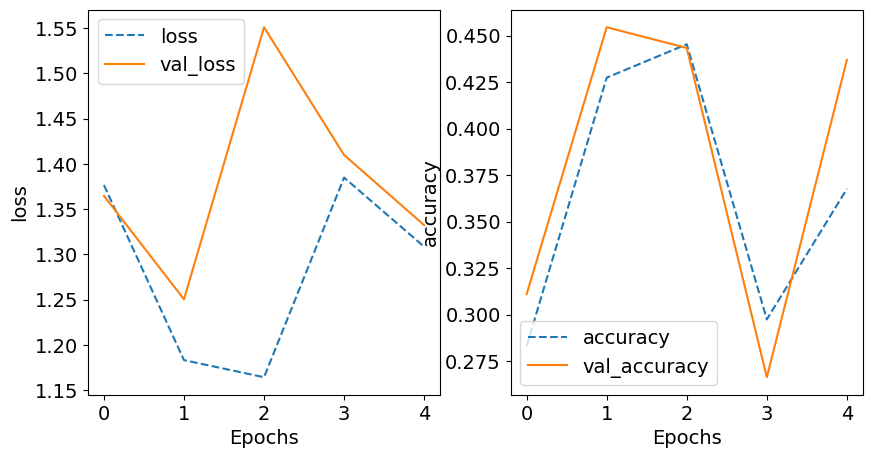

In [113]:
training_plot(['loss', 'accuracy'], history)

In [114]:
# Evaluate the model
loss, acc = vgg16_model_scratch.evaluate(test_aug_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

11/11 - 7s - 664ms/step - accuracy: 0.4587 - loss: 1.3346
Restored model, accuracy: 45.87%


# pretrained vgg16

In [166]:
import tensorflow as tf

# Load VGG16 pre-trained model
pretrained_model = tf.keras.applications.VGG16(
    weights='imagenet',  # Use pre-trained weights
    include_top=False,  # Exclude the top layers
    input_shape=(128, 128, 3)  # Input shape
)
pretrained_model.trainable = False  # Freeze the pre-trained layers

# Use Functional API for more flexibility
inputs = tf.keras.Input(shape=(128, 128, 3))  # Explicit input layer
x = pretrained_model(inputs)  # Pass inputs through the pre-trained model
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Add global average pooling
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)  # Add classification layer
vgg16_model = tf.keras.Model(inputs=inputs, outputs=outputs)  # Define the full model

# Display the model summary
vgg16_model.summary()


Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_15     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,716,740 (56.14 MB)

 Trainable params: 2,052 (8.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [167]:
import functools
# top5_acc = functools.partial(tf.keras.metrics.SparseTopKCategoricalAccuracy())

vgg16_model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [168]:
history = vgg16_model.fit(train_aug_ds, epochs=100,
                    validation_data=val_aug_ds)

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 65s 811ms/step - accuracy: 0.3525 - loss: 1.3598 - val_accuracy: 0.7113 - val_loss: 0.9446
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 65s 819ms/step - accuracy: 0.6932 - loss: 0.9154 - val_accuracy: 0.7815 - val_loss: 0.7355
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 65s 816ms/step - accuracy: 0.7517 - loss: 0.7491 - val_accuracy: 0.8038 - val_loss: 0.6406
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 65s 820ms/step - accuracy: 0.7794 - loss: 0.6530 - val_accuracy: 0.8006 - val_loss: 0.5902
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 66s 827ms/step - accuracy: 0.7933 - loss: 0.6138 - val_accuracy: 0.8150 - val_loss: 0.5514
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 64s 814ms/step - accuracy: 0.7961 - loss: 0.5779 - val_accuracy: 0.8198 - val_loss: 0.5311
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 65s 821ms/step - accuracy: 0.8056 - loss: 0.5514 - val_accuracy: 0.8134 - val_loss: 0.5058
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 64s 814ms/step - accuracy: 0.8034 - loss: 0.5413 - 

In [169]:
vgg16_model.save("vgg16_model_pretrained.keras")

In [170]:
# Saving the Model
vgg16_model_pretrained = vgg16_model.save("vgg16_model_pretrained.h5")

In [171]:
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

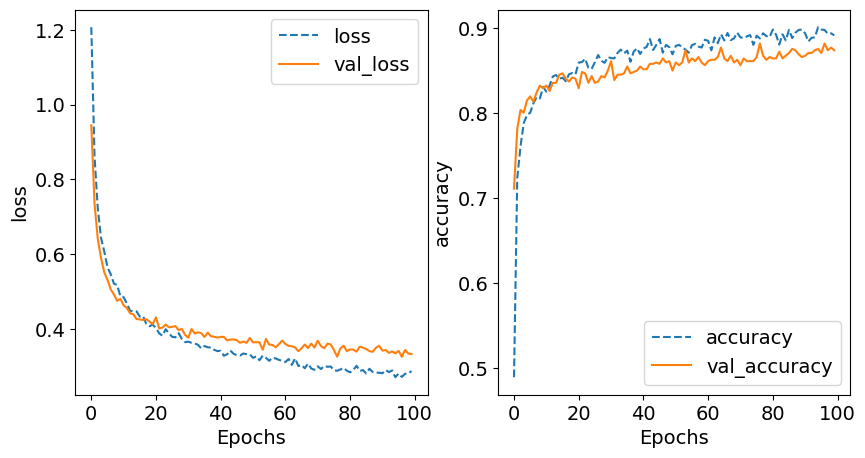

In [172]:
training_plot(['loss', 'accuracy'], history)

In [173]:
vgg16_model_pretrained = tf.keras.models.load_model("vgg16_model_pretrained.keras")    

In [174]:
print(vgg16_model_pretrained)


<Functional name=functional_45, built=True>


In [175]:
# Evaluate the model
loss, acc = vgg16_model_pretrained.evaluate(test_aug_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

11/11 - 8s - 709ms/step - accuracy: 0.8234 - loss: 0.4064
Restored model, accuracy: 82.34%


In [176]:
def plot_image(pred_array, true_label, img):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(pred_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ".format(class_names[predicted_label],
                                100*np.max(pred_array),
                                ),
                                color=color)


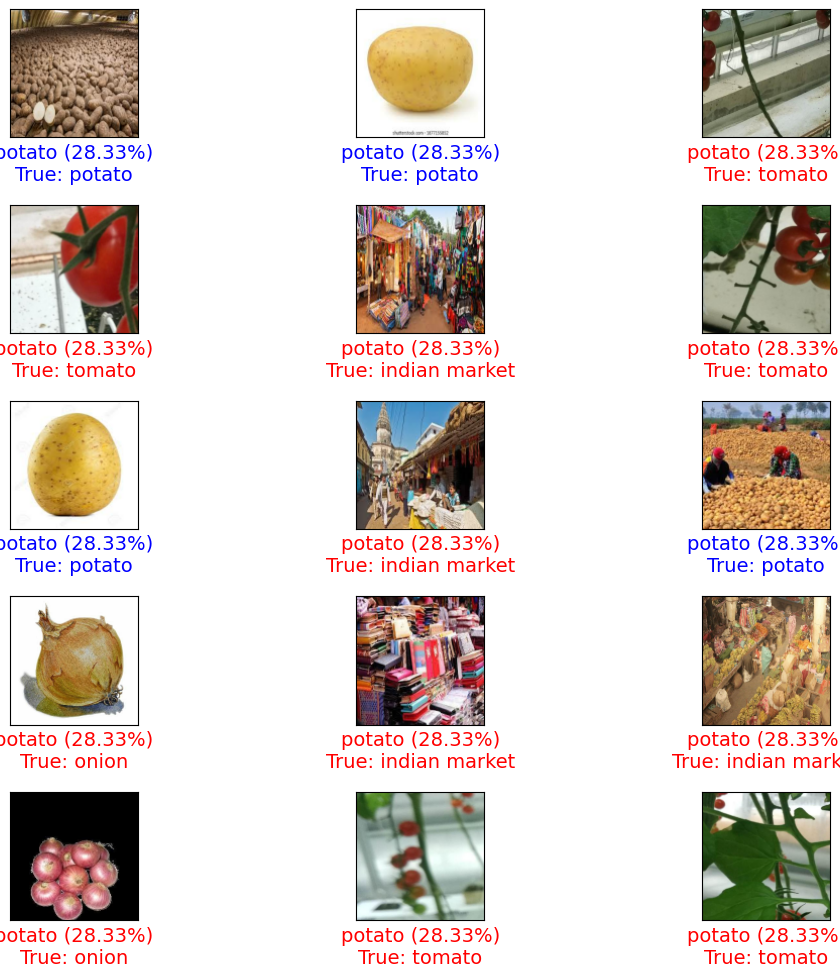

In [177]:
def plot_image(pred_array, true_label, img, class_names):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Convert image back to uint8 if it's normalized
    img = tf.clip_by_value(img, 0.0, 1.0)  # Ensure pixel values are in [0, 1]
    img = (img * 255).numpy().astype("uint8")  # Scale back to [0, 255] if necessary

    # Plot the image
    plt.imshow(img)

    predicted_label = np.argmax(pred_array)
    true_label = np.argmax(true_label)  # Convert one-hot encoded true label to scalar
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(
        f"{class_names[predicted_label]} ({100 * np.max(pred_array):.2f}%)\nTrue: {class_names[true_label]}",
        color=color
    )

# Randomly sample 15 test images and plot them
indices = random.sample(range(len(images)), 15)
num_rows, num_cols = 5, 3
plt.figure(figsize=(4 * num_cols, 2 * num_rows))
for i, index in enumerate(indices):
    plt.subplot(num_rows, num_cols, i + 1)
    plot_image(y_pred[index], true_categories[index], images[index], class_names)

plt.tight_layout()
plt.show()


# Inception net

In [178]:
train_aug_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

InceptionV3 Model Summary:


Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_44 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 2, 2, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,810,980 (83.20 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 21,802,784 (83.17 MB)


ResNet50 Model Summary:


Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_17     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


MobileNetV2 Model Summary:


Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_46 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_18     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.5525 - loss: 1.4390 - val_accuracy: 0.8405 - val_loss: 0.5326
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 194ms/step - accuracy: 0.8231 - loss: 0.4985 - val_accuracy: 0.8676 - val_loss: 0.4103
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 193ms/step - accuracy: 0.8513 - loss: 0.4250 - val_accuracy: 0.8772 - val_loss: 0.3776
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 192ms/step - accuracy: 0.8606 - loss: 0.3870 - val_accuracy: 0.8788 - val_loss: 0.3903
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 192ms/step - accuracy: 0.8591 - loss: 0.3805 - val_accuracy: 0.8533 - val_loss: 0.4980
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 198ms/step - accuracy: 0.8756 - loss: 0.3702 - val_accuracy: 0.8820 - val_loss: 0.4028
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - accuracy: 0.8748 - loss: 0.3693 - val_accuracy: 0.8485 - val_loss: 0.5256
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - accuracy: 0.8781 - loss: 0.3502 - 

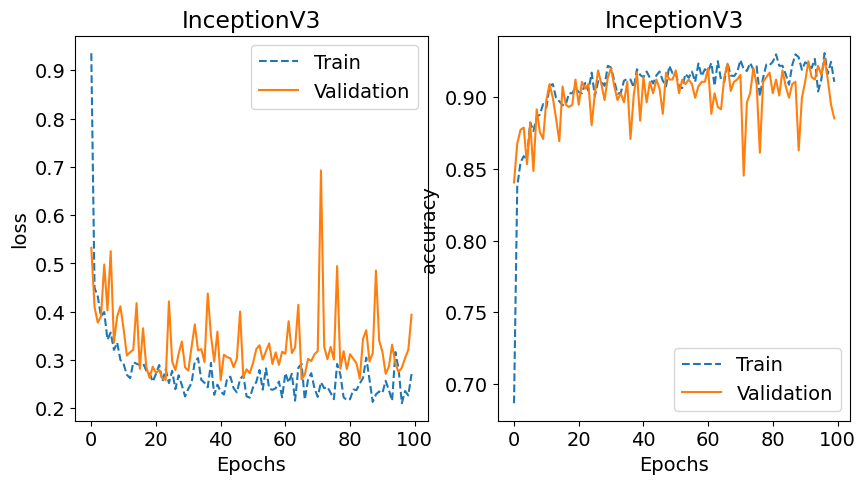

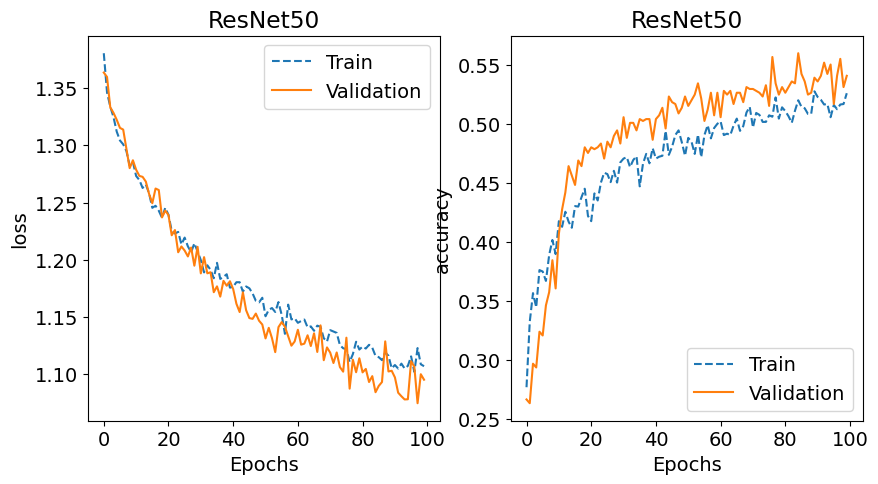

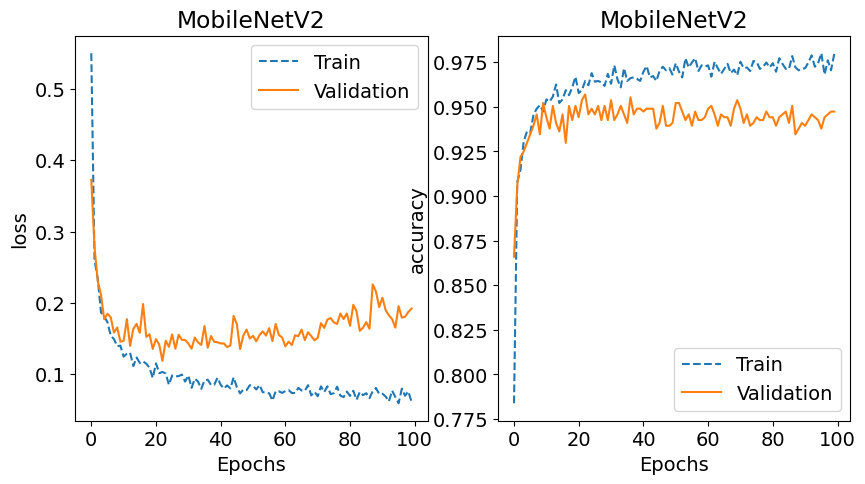

11/11 - 2s - 176ms/step - accuracy: 0.8091 - loss: 0.8076
InceptionV3 Accuracy: 80.91%
11/11 - 4s - 346ms/step - accuracy: 0.4530 - loss: 1.2113
ResNet50 Accuracy: 45.30%
11/11 - 2s - 143ms/step - accuracy: 0.9031 - loss: 0.4149
MobileNetV2 Accuracy: 90.31%
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step


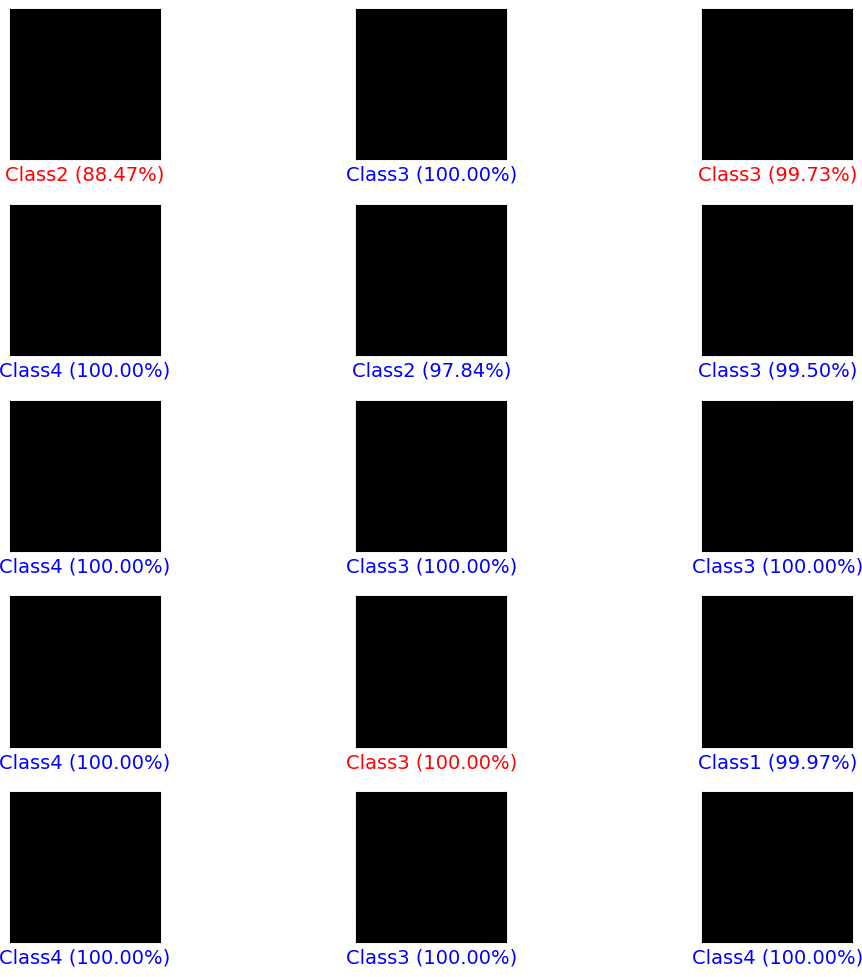

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 460ms/step


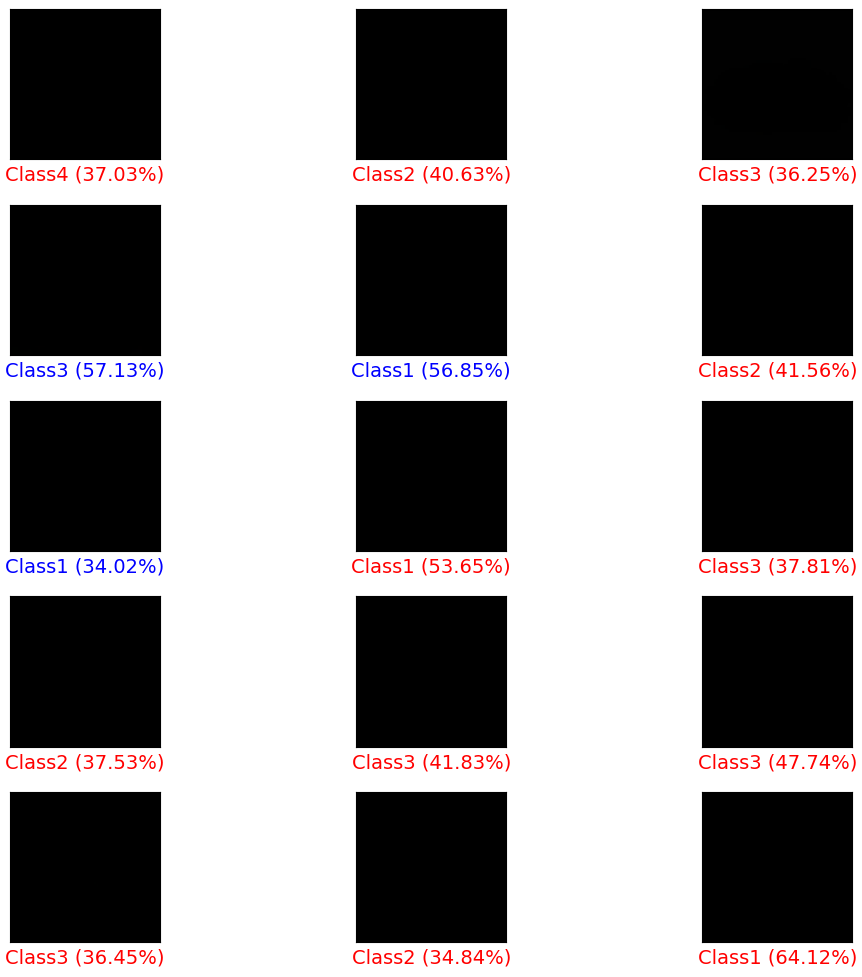

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step


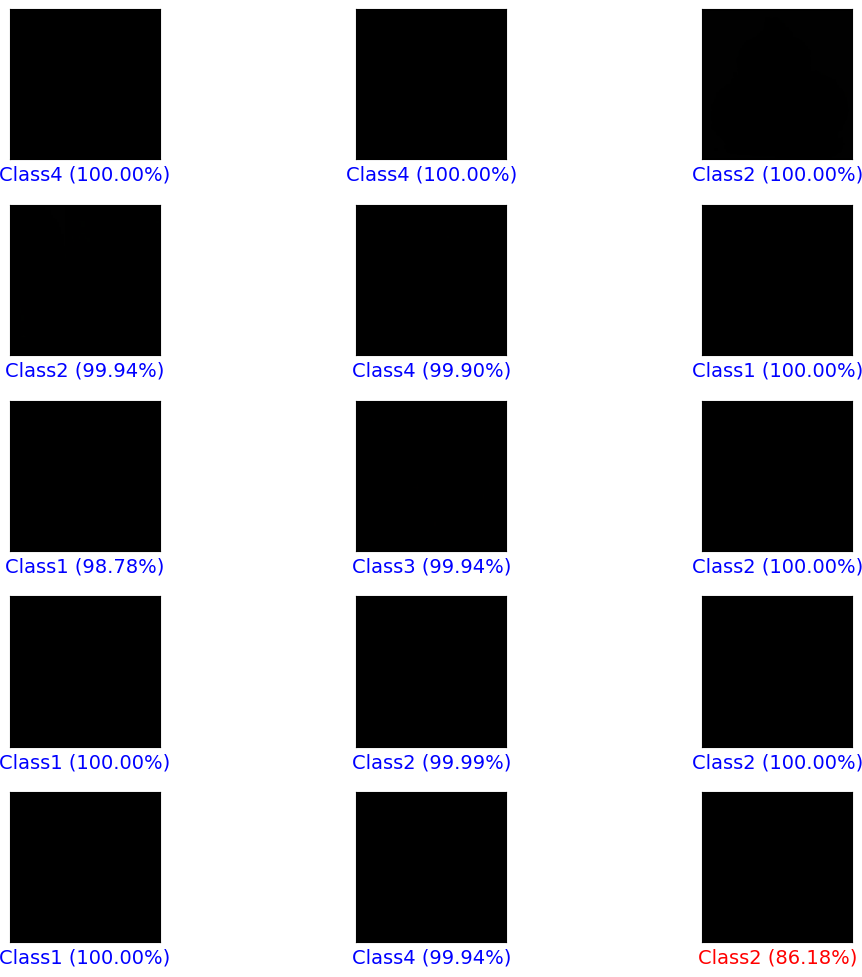

In [179]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import numpy as np

# Assuming you already have the 'class_names' list, no need to extract it from the dataset
# Example:
class_names = ['Class1', 'Class2', 'Class3', 'Class4']  # Replace with your actual class names

# Pre-trained Model Loading and Fine-Tuning Function
def build_pretrained_model(base_model, num_classes, input_shape=(128, 128, 3)):
    base_model.trainable = False  # Freeze the base model layers
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Pre-trained Models
input_shape = (128, 128, 3)
num_classes = len(class_names)  # Set the number of classes dynamically

inception_base = tf.keras.applications.InceptionV3(
    weights='imagenet', include_top=False, input_shape=input_shape
)
resnet_base = tf.keras.applications.ResNet50(
    weights='imagenet', include_top=False, input_shape=input_shape
)
mobilenet_base = tf.keras.applications.MobileNetV2(
    weights='imagenet', include_top=False, input_shape=input_shape
)

# Build Models
inception_model = build_pretrained_model(inception_base, num_classes)
resnet_model = build_pretrained_model(resnet_base, num_classes)
mobilenet_model = build_pretrained_model(mobilenet_base, num_classes)

# Compile Models
def compile_model(model):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

inception_model = compile_model(inception_model)
resnet_model = compile_model(resnet_model)
mobilenet_model = compile_model(mobilenet_model)

# Summary
print("InceptionV3 Model Summary:")
inception_model.summary()
print("\nResNet50 Model Summary:")
resnet_model.summary()
print("\nMobileNetV2 Model Summary:")
mobilenet_model.summary()

# # Training and Validation Data (Replace with your datasets)
# train_aug_ds = ...  # Replace with training dataset
# val_aug_ds = ...  # Replace with validation dataset
# test_aug_ds = ...  # Replace with test dataset

# Training Function
def train_model(model, train_ds, val_ds, epochs, model_name):
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds
    )
    model.save(f"{model_name}.keras")
    return history

# Train Models
epochs = 100
history_inception = train_model(inception_model, train_aug_ds, val_aug_ds, epochs, "inception_model")
history_resnet = train_model(resnet_model, train_aug_ds, val_aug_ds, epochs, "resnet_model")
history_mobilenet = train_model(mobilenet_model, train_aug_ds, val_aug_ds, epochs, "mobilenet_model")

# Training Plot Function
def training_plot(metrics, history, title):
    f, ax = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed', label='Train')
        ax[idx].plot(history.history[f'val_{metric}'], label='Validation')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].legend()
        ax[idx].set_title(title)

# Plot Training Results
training_plot(['loss', 'accuracy'], history_inception, "InceptionV3")
training_plot(['loss', 'accuracy'], history_resnet, "ResNet50")
training_plot(['loss', 'accuracy'], history_mobilenet, "MobileNetV2")
plt.show()

# Evaluate Models
def evaluate_model(model, test_ds, model_name):
    loss, acc = model.evaluate(test_ds, verbose=2)
    print(f"{model_name} Accuracy: {acc * 100:.2f}%")

evaluate_model(inception_model, test_aug_ds, "InceptionV3")
evaluate_model(resnet_model, test_aug_ds, "ResNet50")
evaluate_model(mobilenet_model, test_aug_ds, "MobileNetV2")

# Plot Predictions
def plot_predictions(model, test_ds, class_names):
    true_categories = tf.concat([y for x, y in test_ds], axis=0)
    images = tf.concat([x for x, y in test_ds], axis=0)
    y_pred = model.predict(test_ds)

    indices = random.sample(range(len(images)), 15)
    num_rows, num_cols = 5, 3
    plt.figure(figsize=(4 * num_cols, 2 * num_rows))
    for i, index in enumerate(indices):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.grid(False)
        plt.xticks([])  # Hide x-axis ticks
        plt.yticks([])  # Hide y-axis ticks
        plt.imshow(images[index].numpy().astype("uint8"))
        predicted_label = np.argmax(y_pred[index])
        true_label = np.argmax(true_categories[index])
        color = 'blue' if predicted_label == true_label else 'red'
        plt.xlabel(f"{class_names[predicted_label]} ({100 * np.max(y_pred[index]):.2f}%)", color=color)
    plt.tight_layout()
    plt.show()

# Plot Predictions for All Models
plot_predictions(inception_model, test_aug_ds, class_names)
plot_predictions(resnet_model, test_aug_ds, class_names)
plot_predictions(mobilenet_model, test_aug_ds, class_names)


In [ ]:
inception

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step


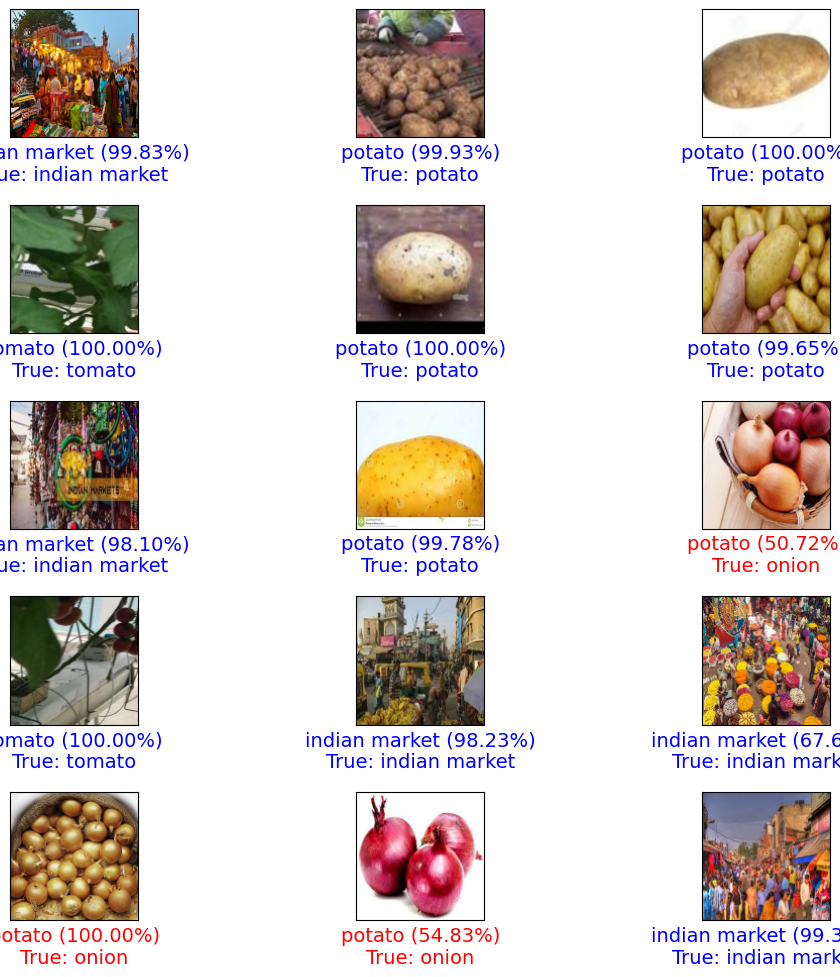

In [187]:
# Define plot function for images
def plot_image(pred_array, true_label, img, class_names):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = tf.clip_by_value(img, 0.0, 1.0)  # Ensure pixel values are in [0, 1]
    img = (img * 255).numpy().astype("uint8")  # Scale back to [0, 255] if necessary

    # Plot the image
    plt.imshow(img)

    predicted_label = np.argmax(pred_array)
    true_label = np.argmax(true_label)  # Convert one-hot encoded true label to scalar
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(
        f"{class_names[predicted_label]} ({100 * np.max(pred_array):.2f}%)\nTrue: {class_names[true_label]}",
        color=color
    )

# Randomly sample 15 test images and plot them
true_categories = tf.concat([y for x, y in test_aug_ds], axis=0)
images = tf.concat([x for x, y in test_aug_ds], axis=0)
y_pred = inception_model.predict(test_aug_ds)
class_names = test_data.class_names

indices = random.sample(range(len(images)), 15)
num_rows, num_cols = 5, 3
plt.figure(figsize=(4 * num_cols, 2 * num_rows))
for i, index in enumerate(indices):
    plt.subplot(num_rows, num_cols, i + 1)
    plot_image(y_pred[index], true_categories[index], images[index], class_names)

plt.tight_layout()
plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 516ms/step


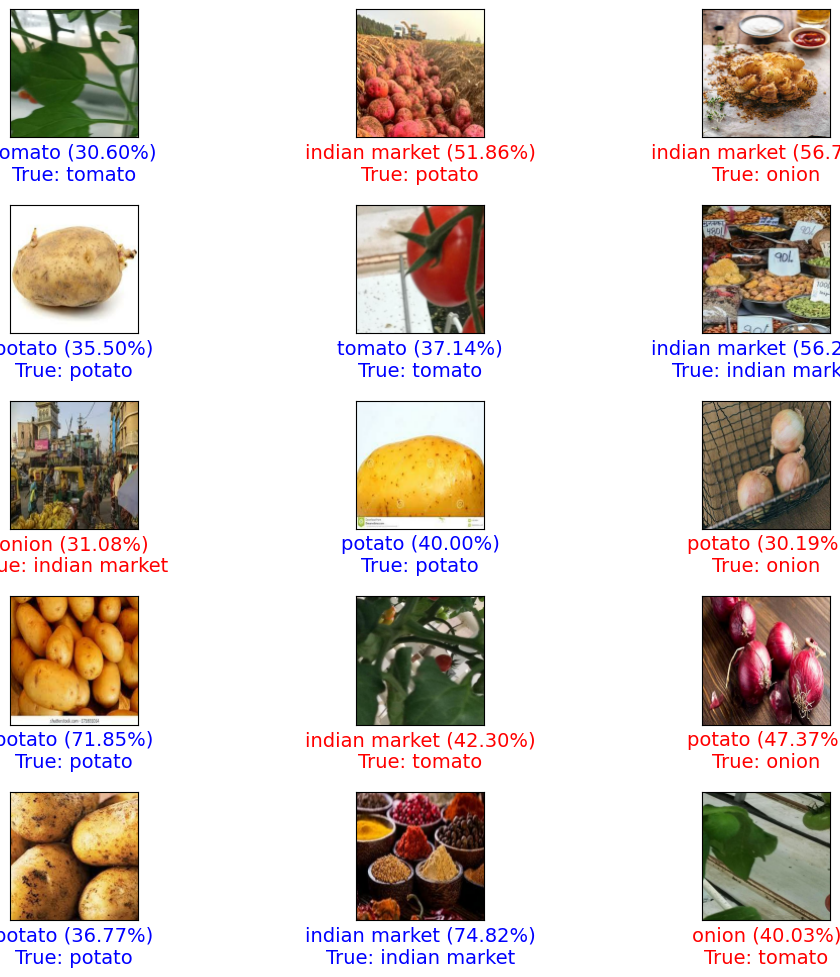

In [188]:
# Define plot function for images
def plot_image(pred_array, true_label, img, class_names):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = tf.clip_by_value(img, 0.0, 1.0)  # Ensure pixel values are in [0, 1]
    img = (img * 255).numpy().astype("uint8")  # Scale back to [0, 255] if necessary

    # Plot the image
    plt.imshow(img)

    predicted_label = np.argmax(pred_array)
    true_label = np.argmax(true_label)  # Convert one-hot encoded true label to scalar
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(
        f"{class_names[predicted_label]} ({100 * np.max(pred_array):.2f}%)\nTrue: {class_names[true_label]}",
        color=color
    )

# Randomly sample 15 test images and plot them
true_categories = tf.concat([y for x, y in test_aug_ds], axis=0)
images = tf.concat([x for x, y in test_aug_ds], axis=0)
y_pred = resnet_model.predict(test_aug_ds)
class_names = test_data.class_names

indices = random.sample(range(len(images)), 15)
num_rows, num_cols = 5, 3
plt.figure(figsize=(4 * num_cols, 2 * num_rows))
for i, index in enumerate(indices):
    plt.subplot(num_rows, num_cols, i + 1)
    plot_image(y_pred[index], true_categories[index], images[index], class_names)

plt.tight_layout()
plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step


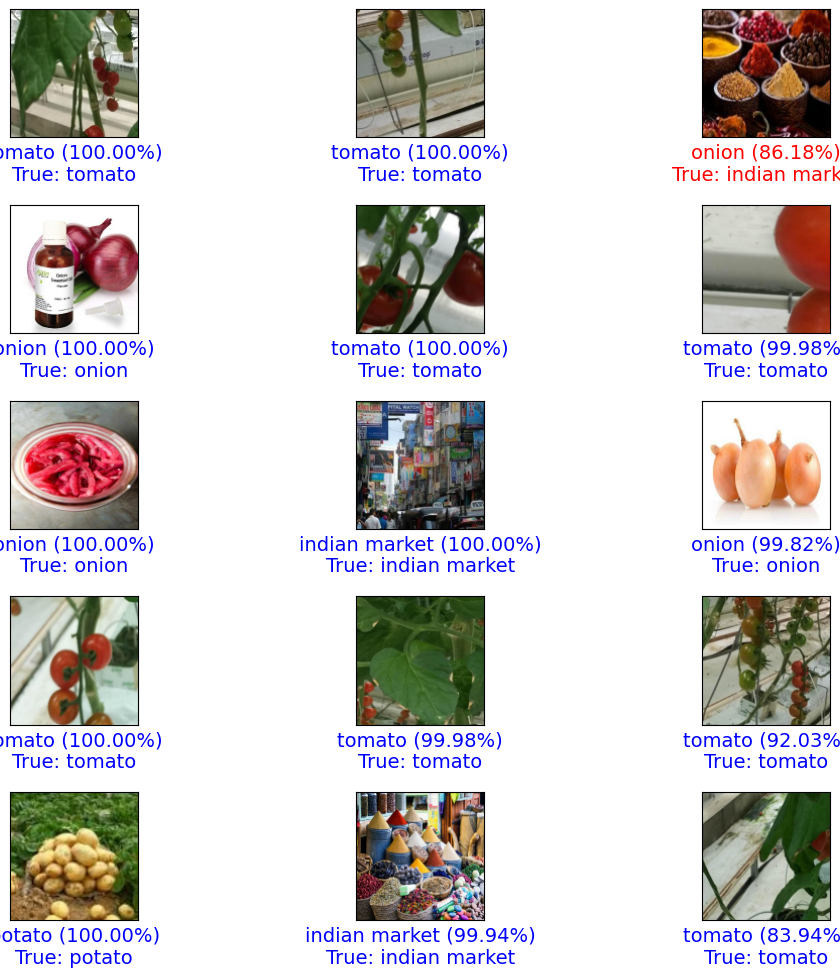

In [189]:
# Define plot function for images
def plot_image(pred_array, true_label, img, class_names):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = tf.clip_by_value(img, 0.0, 1.0)  # Ensure pixel values are in [0, 1]
    img = (img * 255).numpy().astype("uint8")  # Scale back to [0, 255] if necessary

    # Plot the image
    plt.imshow(img)

    predicted_label = np.argmax(pred_array)
    true_label = np.argmax(true_label)  # Convert one-hot encoded true label to scalar
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(
        f"{class_names[predicted_label]} ({100 * np.max(pred_array):.2f}%)\nTrue: {class_names[true_label]}",
        color=color
    )

# Randomly sample 15 test images and plot them
true_categories = tf.concat([y for x, y in test_aug_ds], axis=0)
images = tf.concat([x for x, y in test_aug_ds], axis=0)
y_pred = mobilenet_model.predict(test_aug_ds)
class_names = test_data.class_names

indices = random.sample(range(len(images)), 15)
num_rows, num_cols = 5, 3
plt.figure(figsize=(4 * num_cols, 2 * num_rows))
for i, index in enumerate(indices):
    plt.subplot(num_rows, num_cols, i + 1)
    plot_image(y_pred[index], true_categories[index], images[index], class_names)

plt.tight_layout()
plt.show()


In [180]:
class_names

['Class1', 'Class2', 'Class3', 'Class4']

# Alexnet

In [181]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import random
import numpy as np

# Define AlexNet architecture
def alexnet_model(input_shape=(128, 128, 3), num_classes=4):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        layers.Conv2D(256, (5, 5), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Create AlexNet model
alexnet = alexnet_model(input_shape=(128, 128, 3), num_classes=4)

# Compile the model
alexnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
alexnet.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_405 (Conv2D)             │ (None, 32, 32, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 15, 15, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_406 (Conv2D)             │ (None, 15, 15, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_407 (Conv2D)             │ (None, 7, 7, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_408 (Conv2D)             │ (None, 7, 7, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_409 (Conv2D)             │ (None, 7, 7, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 4096)           │     9,441,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,986,180 (114.39 MB)

 Trainable params: 29,986,180 (114.39 MB)

 Non-trainable params: 0 (0.00 B)

In [182]:
# Train the model
history = alexnet.fit(
    train_aug_ds,
    epochs=100,
    validation_data=val_aug_ds
)


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 340ms/step - accuracy: 0.2929 - loss: 1.5153 - val_accuracy: 0.2663 - val_loss: 1.3801
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 334ms/step - accuracy: 0.3004 - loss: 1.3711 - val_accuracy: 0.2663 - val_loss: 1.3808
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 331ms/step - accuracy: 0.3126 - loss: 1.3714 - val_accuracy: 0.2663 - val_loss: 1.3795
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 330ms/step - accuracy: 0.3001 - loss: 1.3724 - val_accuracy: 0.2663 - val_loss: 1.3793
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 331ms/step - accuracy: 0.3113 - loss: 1.3711 - val_accuracy: 0.2663 - val_loss: 1.3791
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 332ms/step - accuracy: 0.3117 - loss: 1.3715 - val_accuracy: 0.2663 - val_loss: 1.3792
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 329ms/step - accuracy: 0.3085 - loss: 1.3707 - val_accuracy: 0.2663 - val_loss: 1.3795
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 331ms/step - accuracy: 0.3031 - loss: 1.3716 - 

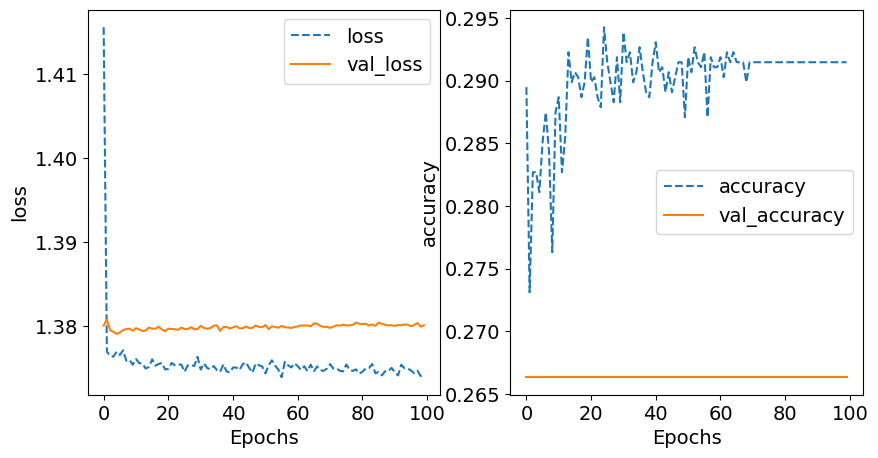

In [183]:
# Plot training history
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric])
        ax[idx].legend([metric, 'val_' + metric])

training_plot(['loss', 'accuracy'], history)


In [184]:
# Evaluate the model on the test data
loss, acc = alexnet.evaluate(test_aug_ds, verbose=2)
print(f"AlexNet model accuracy: {acc * 100:.2f}%")


11/11 - 1s - 70ms/step - accuracy: 0.2308 - loss: 1.3970
AlexNet model accuracy: 23.08%


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


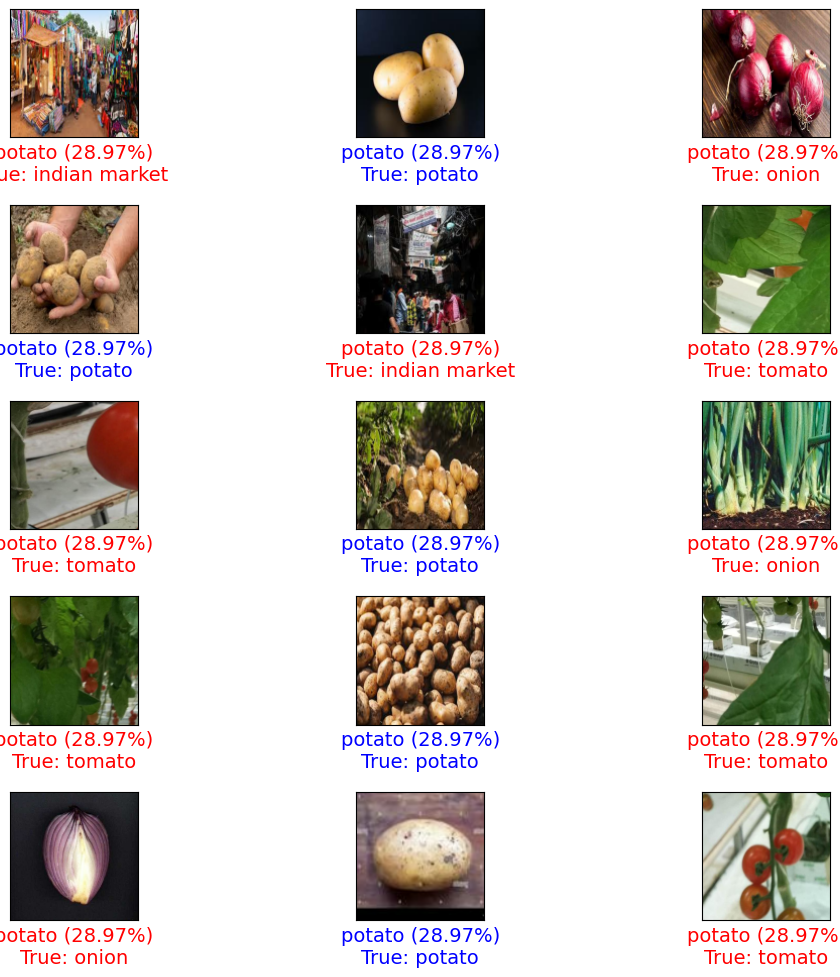

In [185]:
# Define plot function for images
def plot_image(pred_array, true_label, img, class_names):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = tf.clip_by_value(img, 0.0, 1.0)  # Ensure pixel values are in [0, 1]
    img = (img * 255).numpy().astype("uint8")  # Scale back to [0, 255] if necessary

    # Plot the image
    plt.imshow(img)

    predicted_label = np.argmax(pred_array)
    true_label = np.argmax(true_label)  # Convert one-hot encoded true label to scalar
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(
        f"{class_names[predicted_label]} ({100 * np.max(pred_array):.2f}%)\nTrue: {class_names[true_label]}",
        color=color
    )

# Randomly sample 15 test images and plot them
true_categories = tf.concat([y for x, y in test_aug_ds], axis=0)
images = tf.concat([x for x, y in test_aug_ds], axis=0)
y_pred = alexnet.predict(test_aug_ds)
class_names = test_data.class_names

indices = random.sample(range(len(images)), 15)
num_rows, num_cols = 5, 3
plt.figure(figsize=(4 * num_cols, 2 * num_rows))
for i, index in enumerate(indices):
    plt.subplot(num_rows, num_cols, i + 1)
    plot_image(y_pred[index], true_categories[index], images[index], class_names)

plt.tight_layout()
plt.show()
